LSTM

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Baixar dados históricos da ação MGLU3 dos últimos 5 anos
mglu3 = yf.download('MGLU3.SA', period="5y")


[*********************100%***********************]  1 of 1 completed


In [3]:
mglu3.head()

Price,Close,High,Low,Open,Volume
Ticker,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA,MGLU3.SA
Date,,,,,
2020-02-17,137.211365,139.706110,133.247736,135.229550,7887668
2020-02-18,135.742493,137.794249,134.063784,135.812450,4087784
2020-02-19,134.903137,137.327941,134.320249,136.045590,3903890
2020-02-20,131.825485,135.532641,130.170101,135.066342,4763914
2020-02-21,131.615662,134.809870,129.167534,129.750422,4099331


In [4]:
# Pega somente o atributo "Close" e armazena em um array bidimensional
#O array precisa ser bidimensional porque o MinMaxScaler espera uma entrada com esse formato.
mglu3_close = mglu3['Close'].dropna().to_numpy().reshape(-1, 1)

In [5]:
# Criar um DataFrame com os valores ajustados
data = pd.DataFrame(mglu3_close)
data.columns = ['Close']

In [6]:
# Normalizar os dados para os modelos
scaler = MinMaxScaler(feature_range=(0, 1))
data['Scaled_Close'] = scaler.fit_transform(data[['Close']])

In [7]:
# Função para criar janelas de dados
# janela de dados = quantidade de dias do X
def create_dataset(data, window_size=60):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [8]:
window_size = 30
scaled_data = data['Scaled_Close'].values
X, y = create_dataset(scaled_data, window_size)

In [9]:
scaled_data.shape, X.shape, y.shape

((1245,), (1215, 30), (1215,))

In [10]:
# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
# Ajustar o formato para o LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [12]:
# Criar o modelo LSTM
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(100),
    Dropout(0.3),
    Dense(1)
])

C:\Users\ramon\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Compilar o modelo
# A função de loss é a forma de medir o erro do modelo, que nesse caso
#é o classico erro médio quadrático da que é usado em regressão linear
#otimizador e medida de erro

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [14]:
# Treinar o modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

lstm_model.fit(X_train, y_train, 
               epochs=100, 
               batch_size=32, 
               validation_data=(X_test, y_test),
               callbacks=[early_stopping, reduce_lr], 
               verbose=1)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0635 - val_loss: 3.0131e-05 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0046 - val_loss: 3.8904e-05 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0051 - val_loss: 6.0363e-05 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0039 - val_loss: 2.1813e-05 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0034 - val_loss: 5.4902e-05 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0045 - val_loss: 2.8464e-05 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0030 - val_loss: 2.0871e-05 - learning_rate: 5.0000e-04
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0030 - val_loss: 2.9204e-05 - learning_rate: 5.0000e-04
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0029 - val_loss: 2

In [15]:
# Fazer previsões
lstm_predictions = lstm_model.predict(X_test)

# Inverter a normalização
lstm_predictions = scaler.inverse_transform(lstm_predictions)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [ ]:
df_teste = pd.DataFrame({
    "Date": mglu3.index[len(X_train) + window_size : len(X_train) + window_size + len(lstm_predictions)],
    "Real": mglu3['Close'].iloc[len(X_train) + window_size : len(X_train) + window_size + len(lstm_predictions)].values.flatten(),
    "Previsão": lstm_predictions.flatten()
})

df_teste["Date"] = pd.to_datetime(df_teste["Date"])

df_teste.set_index("Date", inplace=True)

In [18]:
df_teste

,Real,Previsão
Date,,
2024-03-01,22.200001,20.656740
2024-03-04,21.299999,20.782940
2024-03-05,21.200001,20.902523
2024-03-06,20.600000,21.009180
2024-03-07,20.400000,21.082945
...,...,...
2025-02-11,7.270000,6.463737
2025-02-12,7.090000,6.537376
2025-02-13,7.010000,6.597289


In [19]:
# Calcular métricas
mae = mean_absolute_error(df_teste["Real"], df_teste["Previsão"])
mse = mean_squared_error(df_teste["Real"], df_teste["Previsão"])
rmse = np.sqrt(mse)
r2 = r2_score(df_teste["Real"], df_teste["Previsão"])

# Exibir resultados
print(f"📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊")
print(f"MAE  (Erro Absoluto Médio)  : {mae:.4f}")
print(f"MSE  (Erro Quadrático Médio): {mse:.4f}")
print(f"RMSE (Raiz do Erro Médio)   : {rmse:.4f}")
print(f"R²   (Coeficiente de Determinação): {r2:.4f}")


📊 MÉTRICAS DE ERRO DO MODELO LSTM 📊
MAE  (Erro Absoluto Médio)  : 0.9031
MSE  (Erro Quadrático Médio): 1.2236
RMSE (Raiz do Erro Médio)   : 1.1062
R²   (Coeficiente de Determinação): 0.9162


In [ ]:
#o preço é legal, mas o importante é acertar pra qual mercado o lado vai. Sera q isso foi feito?

#calcular media de acertos e expectativa de lucro

df_teste['variacao_percentual_acao'] = df_teste['Real'].pct_change()
df_teste['variacao_percentual_modelo'] = df_teste['Previsão'].pct_change()

df_teste = df_teste.dropna()

df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0, 
                                                      True, False)
df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0, 
                                                      True, False)

df_teste['acertou_o_lado'] = np.where(df_teste['var_acao_maior_menor_que_zero'] == df_teste['var_modelo_maior_menor_que_zero']
                                      , True, False)

df_teste['variacao_percentual_acao_abs'] = df_teste['variacao_percentual_acao'].abs()

df_teste

C:\Users\ramon\AppData\Local\Temp\ipykernel_16556\3409855710.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['var_acao_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_acao'] > 0,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16556\3409855710.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste['var_modelo_maior_menor_que_zero'] = np.where(df_teste['variacao_percentual_modelo'] > 0,
C:\Users\ramon\AppData\Local\Temp\ipykernel_16556\3409855710.py:15: SettingWithCopyWarning

,Real,Previsão,Real_Variacao,Previsao_Variacao,Acertou_Direcao,Erro_Percentual,variacao_percentual_acao,variacao_percentual_modelo,var_acao_maior_menor_que_zero,var_modelo_maior_menor_que_zero,acertou_o_lado,variacao_percentual_acao_abs
Date,,,,,,,,,,,,
2024-03-04,21.299999,20.782940,-0.900002,0.126200,False,0.024275,-0.040541,0.006109,False,True,False,0.040541
2024-03-05,21.200001,20.902523,-0.099998,0.119583,False,0.014032,-0.004695,0.005754,False,True,False,0.004695
2024-03-06,20.600000,21.009180,-0.600000,0.106657,False,0.019863,-0.028302,0.005103,False,True,False,0.028302
2024-03-07,20.400000,21.082945,-0.200001,0.073765,False,0.033478,-0.009709,0.003511,False,True,False,0.009709
2024-03-08,20.500000,21.116058,0.100000,0.033113,True,0.030052,0.004902,0.001571,True,True,True,0.004902
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-11,7.270000,6.463737,0.010000,0.084490,True,0.110903,0.001377,0.013245,True,True,True,0.001377
2025-02-12,7.090000,6.537376,-0.180000,0.073638,False,0.077944,-0.024759,0.011393,False,True,False,0.024759
2025-02-13,7.010000,6.597289,-0.080000,0.059913,False,0.058875,-0.011283,0.009165,False,True,False,0.011283


In [ ]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])

errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()


In [60]:
media_lucro.mean()

acertou_o_lado
False    0.033058
True     0.030172
Name: variacao_percentual_acao_abs, dtype: float64

In [ ]:
acertou_lado = df_teste['acertou_o_lado'].sum()/len(df_teste['acertou_o_lado'])

errou_lado = 1 - acertou_lado

media_lucro = df_teste.groupby('acertou_o_lado')['variacao_percentual_acao_abs'].mean()

exp_mat_lucro = acertou_lado * media_lucro[1] - media_lucro[0] * errou_lado

ganho_sobre_perda = media_lucro[1]/media_lucro[0]

exp_mat_lucro_percent = exp_mat_lucro * 100

print(f"Media lucro: {media_lucro}")
print(f"Ganho sobre perda: {ganho_sobre_perda}")
print(f"Acertou lado: {acertou_lado}")
#formate o valor abaixo para 4 casas decimais

print("rendimento diário: " + str(round(exp_mat_lucro_percent, 4)) + "%")


In [50]:
# Calcular se a previsão acertou a direção do movimento do preço
df_teste["Real_Variacao"] = df_teste["Real"].diff().fillna(0)
df_teste["Previsao_Variacao"] = df_teste["Previsão"].diff().fillna(0)

# Se ambos forem positivos ou negativos, significa que a direção foi prevista corretamente
df_teste["Acertou_Direcao"] = (df_teste["Real_Variacao"] * df_teste["Previsao_Variacao"]) > 0

# Calcular taxa de acerto na direção
taxa_acerto_direcao = df_teste["Acertou_Direcao"].mean() * 100

# Calcular erro percentual médio (MAPE - Mean Absolute Percentage Error)
df_teste["Erro_Percentual"] = abs(df_teste["Real"] - df_teste["Previsão"]) / df_teste["Real"]
mape = df_teste["Erro_Percentual"].mean() * 100  # Convertendo para porcentagem

# Exibir métricas de acerto
print(f"✅ Taxa de acerto da direção do movimento: {taxa_acerto_direcao:.2f}%")
print(f"📉 Erro percentual médio (MAPE): {mape:.2f}%")

✅ Taxa de acerto da direção do movimento: 52.89%
📉 Erro percentual médio (MAPE): 7.86%


C:\Users\ramon\AppData\Local\Temp\ipykernel_16556\2039179822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste["Real_Variacao"] = df_teste["Real"].diff().fillna(0)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16556\2039179822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_teste["Previsao_Variacao"] = df_teste["Previsão"].diff().fillna(0)
C:\Users\ramon\AppData\Local\Temp\ipykernel_16556\2039179822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

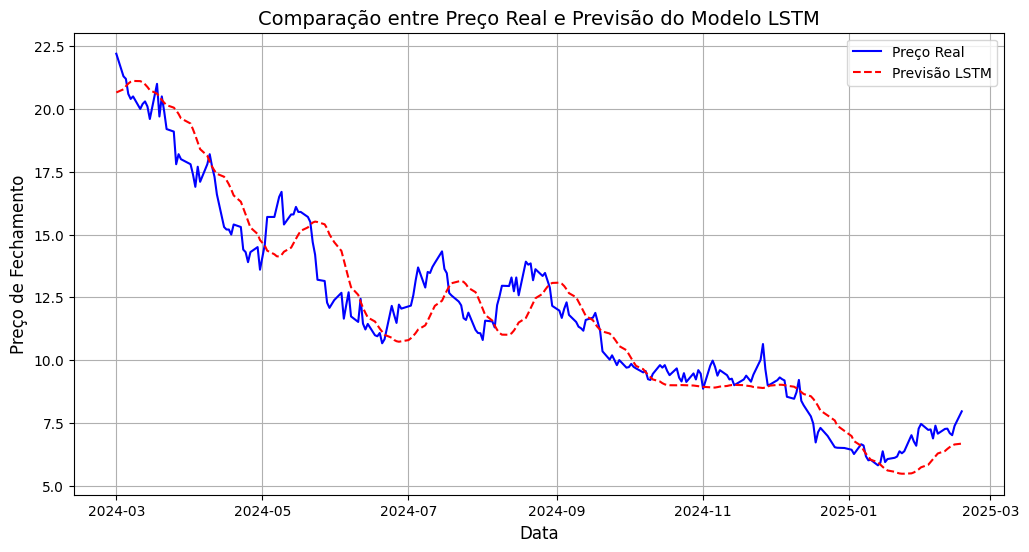

In [20]:
import matplotlib.pyplot as plt

# Criar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_teste.index, df_teste["Real"], label="Preço Real", linestyle="-", color="blue")
plt.plot(df_teste.index, df_teste["Previsão"], label="Previsão LSTM", linestyle="--", color="red")

# Adicionar títulos e legendas
plt.title("Comparação entre Preço Real e Previsão do Modelo LSTM", fontsize=14)
plt.xlabel("Data", fontsize=12)
plt.ylabel("Preço de Fechamento", fontsize=12)
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.show()


In [21]:
# Prever o preço de fechamento para os próximos 5 dias
predicted_prices = []
last_window_days = scaled_data[-window_size:]  # Última janela da série (valores reais)
last_window_days = last_window_days.reshape(1, window_size, 1)  # Ajustar a forma para o LSTM

for _ in range(5):  # Loop para prever os próximos 5 dias
    # Prever o próximo dia
    predicted_price_scaled = lstm_model.predict(last_window_days)
    predicted_price = scaler.inverse_transform(predicted_price_scaled)
    
    # Adicionar a previsão à lista de preços previstos
    predicted_prices.append(predicted_price[0][0])
    
    # Atualizar 'last_window_days' com o novo preço previsto
    last_window_days = np.append(last_window_days[:, 1:, :], predicted_price_scaled.reshape(1, 1, 1), axis=1)

# Exibir os preços previstos para os próximos 5 dias
for i, price in enumerate(predicted_prices, 1):
    print(f"Preço previsto para o dia {i} (amanhã): R${price:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Preço previsto para o dia 1 (amanhã): R$6.71
Preço previsto para o dia 2 (amanhã): R$6.74
Preço previsto para o dia 3 (amanhã): R$6.75
Preço previsto para o dia 4 (amanhã): R$6.74
Preço previsto para o dia 5 (amanhã): R$6.71
